# Find sentiment for a ticker via 10Q filings

### Start

In [4]:
import os, re, json, math, time, requests, numpy as np, pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime, timezone, timedelta
from dotenv import load_dotenv

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from sentence_transformers import SentenceTransformer  # optional (we won't persist embeddings here)

import json
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# CONFIG
# -----------------------
FINBERT = "yiyanghkust/finbert-tone"
AV_BASE = "https://www.alphavantage.co/query"
def SEC_HEADERS(host: str | None = None):
    h = {
        "User-Agent": f"crowdquant (contact: {os.getenv('SEC_EMAIL','email@example.com')})",
        "Accept-Encoding": "gzip, deflate",
    }
    # Only set Host if you explicitly pass one (you usually don't need to)
    if host:
        h["Host"] = host
    return h

load_dotenv()

True

In [5]:
def load_finbert():
    tok = AutoTokenizer.from_pretrained(FINBERT)
    mdl = AutoModelForSequenceClassification.from_pretrained(FINBERT)
    pipe = TextClassificationPipeline(model=mdl, tokenizer=tok, return_all_scores=True, truncation=True)
    return pipe

def finbert_scores(texts, pipe, max_len=512, batch=16):
    out = []
    for i in range(0, len(texts), batch):
        preds = pipe(texts[i:i+batch], max_length=max_len)
        for row in preds:
            d = {x["label"].lower(): x["score"] for x in row}
            out.append({"pos": d.get("positive",0.0), "neu": d.get("neutral",0.0), "neg": d.get("negative",0.0)})
    return out

# -----------------------
# SEC helpers
# -----------------------
def get_cik(ticker:str) -> str:
    """Return zero-padded CIK string for a ticker."""
    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK0000320193.json"  # known-good to check headers
    # quick ping to ensure headers are ok
    try:
        _ = requests.get(url, headers=SEC_HEADERS(), timeout=10)
    except Exception:
        pass
    # submissions endpoint (reliable for cik)
    url = f"https://data.sec.gov/submissions/CIK{str(0).zfill(10)}.json"  # dummy shape
    # real mapping endpoint:
    # We can call the "company_tickers.json" mapping once and cache
    map_url = "https://www.sec.gov/files/company_tickers.json"
    r = requests.get(map_url, headers=SEC_HEADERS(), timeout=30)  # no forced Host
    r.raise_for_status()
    data = r.json()
    t = ticker.upper()
    for _, rec in data.items():
        if rec.get("ticker","").upper() == t:
            return str(rec["cik_str"]).zfill(10)
    raise ValueError(f"CIK not found for ticker {ticker}")

def list_recent_10q(cik:str, count:int=2):
    """Return recent 10-Q (accession, primaryDoc) tuples."""
    url = f"https://data.sec.gov/submissions/CIK{cik}.json"
    r = requests.get(url, headers=SEC_HEADERS(), timeout=30)
    r.raise_for_status()
    js = r.json()
    forms = js.get("filings",{}).get("recent",{})
    out = []
    for form, acc, prim in zip(forms.get("form",[]),
                               forms.get("accessionNumber",[]),
                               forms.get("primaryDocument",[])):
        if form == "10-Q":
            out.append((acc.replace("-",""), prim))
        if len(out) >= count:
            break
    return out

def fetch_filing_html(cik:str, accession:str, primary:str) -> str:
    """Download the primary 10-Q html text."""
    base = f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{accession}"
    url  = f"{base}/{primary}"
    r = requests.get(url, headers=SEC_HEADERS(), timeout=60)
    r.raise_for_status()
    return r.text

SECTION_PATTERNS = [
    (r"item\s+2\.\s*management[’']?s discussion and analysis.*?(?=item\s+3\.)", "MD&A"),
    (r"item\s+1a\.\s*risk factors.*?(?=item\s+2\.)", "RiskFactors"),
    (r"item\s+1\.\s*financial statements.*?(?=item\s+2\.)", "FinancialStatementsNarrative"),
    (r"overview.*?(?=results of operations|liquidity|capital resources|risk factors|item\s+\d)", "Overview"),
]
def extract_sections(html:str) -> dict:
    soup = BeautifulSoup(html, "lxml")
    # get text-y version
    txt = soup.get_text("\n", strip=True)
    # normalize whitespace and lowercase copy for regex
    low = re.sub(r"[ \t]+"," ", txt.lower())
    sections = {}
    for pat, name in SECTION_PATTERNS:
        m = re.search(pat, low, flags=re.S)
        if m:
            # map back to original text slice by proportions (approx); or just grab substring from low
            seg_low = low[m.start():m.end()]
            # find the same slice in the original (simple fallback)
            # For robustness, just return the lowercased slice (still fine for sentiment)
            sections[name] = seg_low[:200000]  # cap to avoid giant walls
    # if no sections, fall back to whole doc truncated
    if not sections:
        sections["FullDocument"] = low[:200000]
    return sections

# -----------------------
# XBRL (US-GAAP) Facts
# -----------------------
USGAAP_KEYS = {
    "revenue": ["Revenues","RevenueFromContractWithCustomerExcludingAssessedTax","SalesRevenueNet"],
    "net_income": ["NetIncomeLoss"],
    "eps_diluted": ["EarningsPerShareDiluted"],
    "shares_out": ["CommonStockSharesOutstanding","WeightedAverageNumberOfDilutedSharesOutstanding"],
}

def _pick_latest(values, form_types=None):
    """Pick the most recent value (by end date) optionally filtering form types."""
    if not values: return None
    rows = []
    for v in values:
        if form_types and v.get("form") not in form_types:  # e.g., '10-Q' or '10-K'
            continue
        try:
            end = datetime.fromisoformat(v["end"])
        except Exception:
            continue
        val = v.get("val")
        if val is None: continue
        rows.append((end, float(val)))
    if not rows: return None
    rows.sort(key=lambda x: x[0], reverse=True)
    return rows[0][1]

def get_company_facts(cik:str) -> dict:
    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"
    r = requests.get(url, headers=SEC_HEADERS(), timeout=30)
    r.raise_for_status()
    return r.json()

def ttm_sum(values, months=12):
    """Approximate TTM by summing the last four quarterly values if available."""
    if not values: return None
    rows = []
    for v in values:
        try:
            end = datetime.fromisoformat(v["end"])
        except Exception:
            continue
        dur = v.get("fy")  # not duration; SEC uses "fp" quarter; safer to assume quarterly values appear
        val = v.get("val")
        if val is None: continue
        rows.append((end, float(val)))
    if not rows: return None
    rows.sort(key=lambda x: x[0], reverse=True)
    # take last 4
    arr = [x[1] for x in rows[:4]]
    return float(np.nansum(arr)) if arr else None

def extract_gaap_ttm(facts_json:dict) -> dict:
    out = {}
    facts = facts_json.get("facts",{}).get("us-gaap",{})

    def get_series(keys):
        for k in keys:
            if k in facts:
                return facts[k].get("units",{}).get("USD",[]) or facts[k].get("units",{}).get("shares",[]) or facts[k].get("units",{}).get("USD/shares",[])
        return []

    revenue_vals = get_series(USGAAP_KEYS["revenue"])
    net_vals     = get_series(USGAAP_KEYS["net_income"])
    eps_vals     = get_series(USGAAP_KEYS["eps_diluted"])
    shares_vals  = get_series(USGAAP_KEYS["shares_out"])

    out["revenue_ttm"] = ttm_sum(revenue_vals)
    out["net_income_ttm"] = ttm_sum(net_vals)
    out["eps_diluted_ttm"] = _pick_latest(eps_vals, form_types=None)  # EPS is often TTM-ish already (per period)
    out["shares_out_latest"] = _pick_latest(shares_vals, form_types=None)
    return out

# -----------------------
# Alpha Vantage price
# -----------------------
def latest_price(ticker:str):
    key = os.getenv("ALPHAVANTAGE_API_KEY")
    if not key:
        return None
    params = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": ticker.upper(),
        "apikey": key,
        "outputsize": "compact",
    }
    r = requests.get(AV_BASE, params=params, timeout=30)
    try:
        js = r.json()
        ts = js["Time Series (Daily)"]
        dates = sorted(ts.keys(), reverse=True)
        last = float(ts[dates[0]]["5. adjusted close"])
        return last
    except Exception:
        return None

# -----------------------
# Valuation heuristics
# -----------------------
def fair_value_range(ticker:str, gaap:dict, price:float, target_pe=15.0, target_ps=4.0):
    """Simple two-anchor range using P/E and P/S; returns dict."""
    res = {}
    eps = gaap.get("eps_diluted_ttm")
    rev = gaap.get("revenue_ttm")
    shs = gaap.get("shares_out_latest")
    # P/E anchor
    if eps and eps > 0:
        res["pe_anchor"] = eps * target_pe
    # P/S anchor (per share)
    if rev and shs and shs > 0:
        sales_per_share = rev / shs
        res["ps_anchor"] = sales_per_share * target_ps
    # Combine
    anchors = [v for v in [res.get("pe_anchor"), res.get("ps_anchor")] if v and math.isfinite(v)]
    if anchors:
        res["fair_value_mid"] = float(np.mean(anchors))
        res["fair_value_low"] = float(np.min(anchors))
        res["fair_value_high"] = float(np.max(anchors))
    else:
        res["fair_value_mid"] = None
    res["current_price"] = price
    if price and res.get("fair_value_mid"):
        res["upside_pct"] = 100.0 * (res["fair_value_mid"] / price - 1.0)
    return res

# -----------------------
# 10-Q pipeline
# -----------------------
def analyze_10q(ticker:str, quarters:int=1):
    cik = get_cik(ticker)
    pairs = list_recent_10q(cik, count=max(1, quarters))
    if not pairs:
        raise RuntimeError("No 10-Q filings found.")
    # download and parse sections from each 10-Q
    docs = []
    for acc, prim in pairs:
        html = fetch_filing_html(cik, acc, prim)
        secs = extract_sections(html)
        docs.append({"accession": acc, "primary": prim, "sections": secs})
        time.sleep(0.3)  # be nice

    # sentiment per section
    pipe = load_finbert()
    summary = []
    for doc in docs:
        for name, text in doc["sections"].items():
            sc = finbert_scores([text], pipe)[0]
            summary.append({
                "ticker": ticker.upper(),
                "accession": doc["accession"],
                "section": name,
                "pos": sc["pos"], "neu": sc["neu"], "neg": sc["neg"],
                "sent_score": sc["pos"] - sc["neg"]
            })
    sent_df = pd.DataFrame(summary).sort_values(["accession","section"])

    # fundamentals (TTM) + price + fair value
    facts = get_company_facts(cik)
    gaap = extract_gaap_ttm(facts)
    price = latest_price(ticker)
    value = fair_value_range(ticker, gaap, price)

    return {
        "ticker": ticker.upper(),
        "cik": cik,
        "sentiment": sent_df,
        "gaap_ttm": gaap,
        "valuation": value,
        "filings": [{"accession": d["accession"], "primary": d["primary"]} for d in docs],
    }


### Test the code

Analyzing AAPL …


/var/folders/8r/txvrry2d4g18dhf7jkg1hhzm0000gn/T/ipykernel_80683/2841508360.py:73: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(html, "lxml")
Device set to use mps:0
/Users/severinspagnola/Desktop/project-fa25-QVP/venv/lib/python3.13/site-packages/transformers/pipelines/text_classification.py:111: 

,ticker,accession,section,pos,neu,neg,sent_score
0,AAPL,000032019324000081,FinancialStatementsNarrative,0.000005,0.999961,0.000033,-0.000028
1,AAPL,000032019324000081,MD&A,0.000069,0.999911,0.000021,0.000048
2,AAPL,000032019324000081,RiskFactors,0.051847,0.794658,0.153495,-0.101649
3,AAPL,000032019325000008,FinancialStatementsNarrative,0.000005,0.999961,0.000033,-0.000028
4,AAPL,000032019325000008,MD&A,0.000069,0.999889,0.000042,0.000026
5,AAPL,000032019325000008,RiskFactors,0.051847,0.794658,0.153495,-0.101649
6,AAPL,000032019325000057,FinancialStatementsNarrative,0.000005,0.999961,0.000033,-0.000028
7,AAPL,000032019325000057,MD&A,0.000069,0.999889,0.000042,0.000026
8,AAPL,000032019325000057,RiskFactors,0.110445,0.548444,0.341111,-0.230666
9,AAPL,000032019325000073,FinancialStatementsNarrative,0.000005,0.999961,0.000033,-0.000028


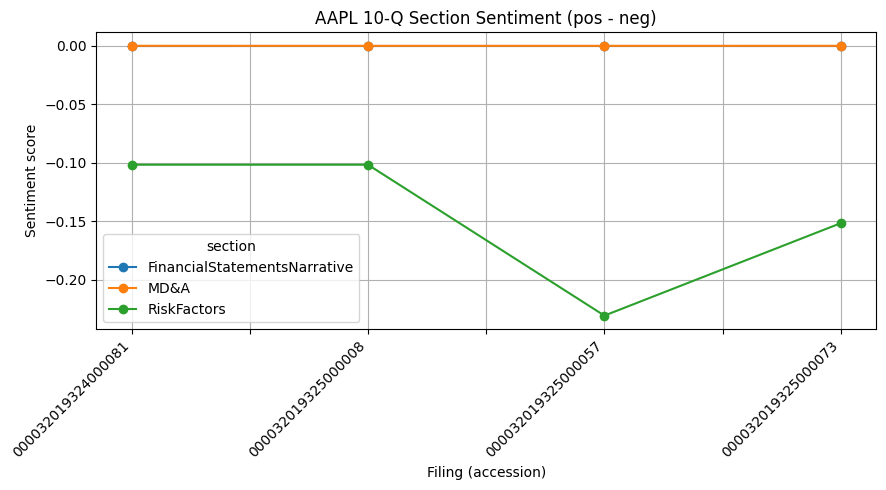

Done. Files saved:  ['sentiment_AAPL.csv', 'valuation_AAPL.json', 'sentiment_trend_AAPL.csv']


In [6]:
# ---- choose your ticker(s) and how many recent 10-Qs to analyze
TICKERS = ["AAPL"]          # add more like ["AAPL","MSFT"] to loop
QUARTERS = 4                # analyze up to 4 most recent 10-Qs (if available)

all_sent = []
all_meta = []

for t in TICKERS:
    print(f"Analyzing {t} …")
    res = analyze_10q(t, quarters=QUARTERS)

    # sentiment table (per filing section)
    sent = res["sentiment"].copy()
    sent["ticker"] = t
    all_sent.append(sent)

    # quick valuation snapshot
    meta = {
        "ticker": t,
        "cik": res["cik"],
        "gaap_ttm": res["gaap_ttm"],
        "valuation": res["valuation"],
        "filings": res["filings"],
    }
    all_meta.append(meta)

    # ---- save artifacts
    sent.to_csv(f"sentiment_{t}.csv", index=False)
    with open(f"valuation_{t}.json","w") as f:
        json.dump(meta, f, indent=2)

# ---- combine sentiment across tickers for convenience
sent_df = pd.concat(all_sent, ignore_index=True) if all_sent else pd.DataFrame()
display(sent_df.head(20))  # quick peek

# ---- Plot sentiment trend (pos-neg) by section across the last filings of the first ticker
if not sent_df.empty:
    tt = TICKERS[0]
    sdf = sent_df[sent_df["ticker"] == tt].copy()

    # make accession order chronological by string (works fine for accessions) and pivot
    sdf = sdf.sort_values(["accession","section"])
    pivot = sdf.pivot_table(index="accession", columns="section", values="sent_score", aggfunc="mean")

    # line plot
    ax = pivot.plot(marker="o", figsize=(9,5))
    ax.set_title(f"{tt} 10-Q Section Sentiment (pos - neg)")
    ax.set_xlabel("Filing (accession)")
    ax.set_ylabel("Sentiment score")
    ax.grid(True)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # also save the pivot to CSV for later comparisons
    pivot.to_csv(f"sentiment_trend_{tt}.csv")

print("Done. Files saved: ",
      [f"sentiment_{t}.csv" for t in TICKERS] +
      [f"valuation_{t}.json" for t in TICKERS] +
      ([f"sentiment_trend_{TICKERS[0]}.csv"] if TICKERS else []))
